In [1]:
import os

os.environ["XLA_FLAGS"] = "--xla_gpu_force_compilation_parallelism=1"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from vbeam.fastmath import backend_manager

backend_manager.active_backend = "jax"

from vbeam.core import ElementGeometry, WaveData, Wavefront
from vbeam.fastmath.traceable import traceable_dataclass
from vbeam.fastmath import numpy as np


@traceable_dataclass(("base_wavefront", "base_sender"))
class REFoCUSWavefront(Wavefront):
    base_wavefront: Wavefront
    base_sender: ElementGeometry

    def transmit_distance(
        self,
        sender: ElementGeometry,
        point_pos: np.ndarray,
        wave_data: WaveData,
    ) -> float:
        transmit_delay_dist = self.base_wavefront.transmit_distance(
            self.base_sender, sender.position, wave_data
        )
        sender_point_dist = np.sqrt(np.sum((sender.position - point_pos) ** 2))
        return sender_point_dist + transmit_delay_dist

In [5]:
mini_scan = setup.scan.resize(azimuths=150, depths=150)
speed_of_sound_values = np.array(np.ones(mini_scan.shape) * 1540.0, dtype="float16")
HeterogeneousSpeedOfSound.from_scan(
    mini_scan, speed_of_sound_values
).n_samples

213

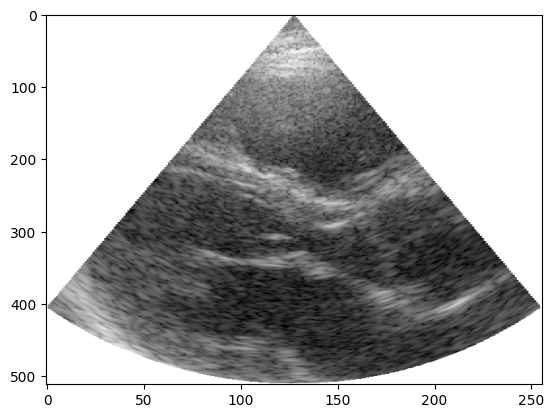

In [2]:
import jax
import jax.numpy as np
import pyuff_ustb as pyuff

from vbeam.core import signal_for_point
from vbeam.data_importers import import_pyuff
from vbeam.postprocess import *
from vbeam.scan import cartesian_map, sector_scan
from vbeam.speed_of_sound import HeterogeneousSpeedOfSound
from vbeam.util.download import cached_download
from vbeam.util.transformations import *
from vbeam.apodization import NoApodization

# Download and read the channel data
data_url = "http://www.ustb.no/datasets/Verasonics_P2-4_parasternal_long_small.uff"
uff = pyuff.Uff(cached_download(data_url))
channel_data = uff.read("/channel_data")

# Import the data
setup = import_pyuff(channel_data, frames=0)

# Define and set a custom sector scan
scan_angles = np.array([wave.source.azimuth for wave in channel_data.sequence])
scan_depths = np.linspace(0e-3, 110e-3, 512)
setup.scan = sector_scan(scan_angles, scan_depths).resize(azimuths=256)

setup.apodization = NoApodization()
setup.wavefront = REFoCUSWavefront(setup.wavefront, setup.sender)
# Set sender to be all elements
setup.sender = setup.receiver
setup.spec = setup.spec.replace({"sender": ["senders"]})

# Use custom REFoCUS wavefront

# Use a speed of sound map
mini_scan = setup.scan.resize(azimuths=150, depths=150)
speed_of_sound_values = np.array(np.ones(mini_scan.shape) * 1540.0, dtype="float16")
setup.speed_of_sound = HeterogeneousSpeedOfSound\
    .from_scan(
    mini_scan, speed_of_sound_values
)

# Define our "custom" beamformer
# We could also just call:
# beamformer = get_das_beamformer(setup)
beamformer = compose(
    # Beamform a single transmit
    signal_for_point,
    # Coherently sum over transmits, as
    # an iterative reduction
    # Process all other items in parallel
    ForAll("points"),
    ForAll("senders"),
    ForAll("receivers"),#, "transmits"),
    # Sum over senders and receivers
    Apply(np.sum, [Axis("senders"), Axis("receivers")]),#, Axis("transmits")]),
    Reduce.Sum("transmits"),
    # Some post-processing steps
    Apply(normalized_decibels),
    Apply(setup.scan.unflatten),
    Apply(cartesian_map, setup.scan),
    # Just-in-time compile using JAX
    Wrap(jax.jit),
).build(setup.spec)
image = beamformer(**setup.data).block_until_ready()

import matplotlib.pyplot as plt

plt.imshow(image.T, aspect="auto", cmap="gray", vmin=-80)

In [3]:
data = setup.data
%timeit beamformer(**data).block_until_ready()
# Full scan speed of sound map
# 16.2 s ± 71.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

# 150x150 speed of sound map
# 6.33 s ± 34.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# (1671MiB)

# With full parallelization
# 1.92 s ± 3.71 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# (2183MiB)

850 ms ± 732 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
(150**2+150**2)**0.5

212.13203435596427

In [4]:
f"{64*131071*64*101/869*1000:.2e}"

'6.24e+10'

Without SOS-map, 6.24e+10 points processed per second, taking 869 ms on average, the whole notebook allocating 1415MiB of GPU memory to due reducing over transmits instead of processing them in parallel.

In [5]:
setup.size()

{'receivers': 64,
 'signal_time': 2176,
 'transmits': 101,
 'points': 131072,
 'senders': 64}